# TP n°2 - Méthodes d’accès Aloha

Dans les réseaux informatiques, pour exploiter efficacement les supports de communication partagés, on a depuis toujours préférés mettre en place des méthodes d’accès dynamiques permettant de tenir compte des besoins des utilisateurs. Parmi ces méthodes, on distingue essentiellement les solutions qui évitent toute collision et celles qui les supportent et entraînent des 
retransmissions ultérieures. 

### Aloha pur
 

On appelle __Aloha pur__, le cas où l’on a une infinité d’utilisateurs partageant un support qui génèrent des trames de taille constante $T$ (que l’on confond avec le temps d’émission) avec un débit global poissonien de taux $\lambda$. Le canal est sans erreur : quand une trame est émise et qu’elle ne rentre en conflit avec aucune autre trame, elle est reçue correctement. Quand deux trames (ou plus) ont des périodes d’émission qui se chevauchent, aucune n’est reçue correctement. À la fin de chaque émission, on suppose que l’utilisateur sait s’il y a eu collision ou non. La population étant infinie, on peut considérer que chaque trame appartient à un utilisateur différent. On ne gère pas alors d’utilisateurs (avec des files d’attente) mais des trames à envoyer ou à renvoyer en cas de collision.

On note alors $\gamma$ le débit des trames émises (ou réémises sur le support) : $\gamma > \lambda$ et $\Lambda$ le débit de trames transmises correctement. On appelle \textbf{capacité du lien} $\rho_{\text{max}}$, la charge maximale de sortie soit encore le débit maximal de sortie multipliée par le temps moyen d’émission $\rho_{\text{max}} = \Lambda_{\text{max}} T$.

Il n’y a pas de modèle exact d’un tel système, les approximations classiques consistent à dire que les émissions de paquets sur le lien constituent un processus de Poisson de paramètre $\gamma$ (la caractérisation de ce processus est extrêmement compliquée mais les études ont montré que si la durée avant retransmission était choisie selon une loi uniforme sur une grande plage de valeurs, cette approximation était raisonnable).

Sous cette approximation, on obtient que la probabilité qu’une transmission soit fructueuse est égale à la probabilité qu’il n’y ait aucun débit de transmission pendant l’intervalle $]-T, T[$ appelé période de vulnérabilité. Il vient :

$$P_{\text{succ}} = e^{-2\gamma T}$$

Soit une proportion de temps pendant laquelle le support est efficacement utilisé

$$\rho = \gamma T e^{-2\gamma T} = G e^{-2G}$$

On trouve alors que $\rho_{\text{max}}$ est atteint pour $G = \frac{1}{2}$ et vaut :

$$\rho_{\text{max}} = \frac{1}{2e} \approx 0.18$$

Utiliser le programme de simulation reproduisant ce premier système (on supposera un grand nombre d’utilisateurs au moins 100). Les temps de retransmissions seront tirés selon une loi uniforme sur $[0, T_{\text{max}}]$, $T_{\text{max}}$ étant un paramètre à faire varier. Observer en fonction du débit d’arrivée, le débit soumis au support $\gamma$ (débit offert), le temps moyen pour transmettre correctement une trame ainsi que la charge efficace du support $\rho$.

Refaire en fixant le débit d’arrivée et variant le nombre maximal de tentatives et la taille des files. On fixera certains paramètres de la simulation :

| Paramètre                                 | Valeurs                    |
|-------------------------------------------|----------------------------|
| Taille de paquet                          | 210 octets                 |
| Débit des liens montant/descendant        | 2 Mbps                     |
| Capacité de la file d’émission au niveau PHY | 50 (à faire varier)     |
| Nombre maximal de tentatives de retransmissions | 3 (à faire varier) |
| Temps moyen de backoff exponentiel        | 1 seconde (à faire varier) |
| Délai de temporisation d’émission         | 270 ms                     |


### 1. Validation de la charge analytique
On cherche à faire varier la charge utile pour obtenir la charge en sortie simulée. Pour ce faire, on va modifier le paramètre $\verb|idle_time|$ qui indique la période de veille des émetteurs afin de faire varier le débit d'arrivée $\lambda$ et donc naturellement la charge utile. En effet, on a : 
$$\lambda=\displaystyle\sum_{i=1}^N\lambda_i=\dfrac{N}{\text{idle\_time}}$$


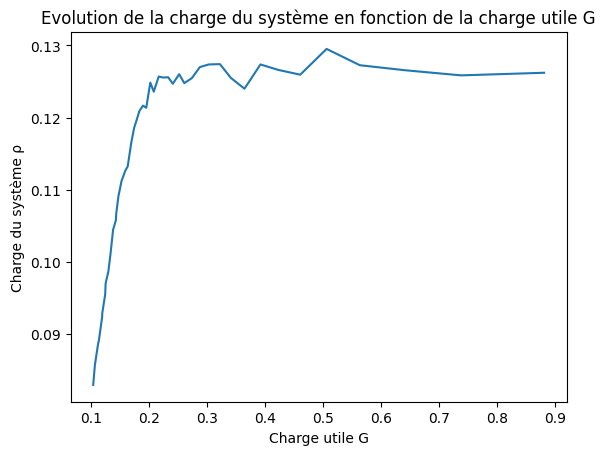

In [4]:
# use python 3.8 
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib import pyplot as plt

mean_backoff = "1s"
num_nodes = 100  # N à faire varier

def run_simulation(idle_time):
    # Create the file path
    file = f"out_{idle_time}.tr"
    file_path = f"./trace_Loss_res/{file}"

    # Create the file
    subprocess.run(["touch", file_path])

    # Run the simulation
    ns = subprocess.run(["ns", "./sat-aloha2.tcl", "poisson", mean_backoff, str(num_nodes), str(idle_time), file], cwd="./trace_Loss_res/", capture_output=True, text=True)
    if ns.returncode != 0: 
        print(f"Simulation error for idle_time {idle_time}: {ns.stderr}")
        return None

    # Process the results
    res = subprocess.run(["perl", "./trace_Loss/loss.pl", file_path], capture_output=True, text=True)
    
    # Remove the file
    subprocess.run(["rm", "-rf", file_path])
    
    if res.returncode == 0 and res.stdout:
        return float(res.stdout.split()[-2]), float(res.stdout.split()[-1])
    else:
        print(f"Processing error for idle_time {idle_time}: {res.stderr}")
        return None

i = 0.1
x, y = [], []
futures = []

# Initialize the ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    while i < 1:
        futures.append(executor.submit(run_simulation, i))
        i += 0.02

    # Gather the results
    for future in as_completed(futures):
        result = future.result()
        if result is not None:
            x_val, y_val = result
            x.append(x_val)
            y.append(y_val)
        else:
            print("Error in the simulation")

# Sort the results
if x and y:  # Ensure there are results to sort
    x, y = zip(*sorted(zip(x, y)))

# Plot the results
plt.plot(x, y)
plt.xlabel("Charge utile G")  
plt.ylabel("Charge du système ρ")
plt.title("Evolution de la charge du système en fonction de la charge utile G")  
plt.show()


### 2. Optimisation du temps de backoff

On chercher maintenant à comprendre l'influencedu temps maximal de backoff $T_{\text{max}}$ et l'optimiser pour déterminer la charge en sortie maximale. On fixe donc $\verb|idle_time|=0,17\Rightarrow G=1/2$ et on trace la charge en sortie ainsi que le temps de réponse moyen fonction du temps moyen de backoff $\verb|mean_backoff|=\dfrac{T_{\text{max}}}{2}$ :

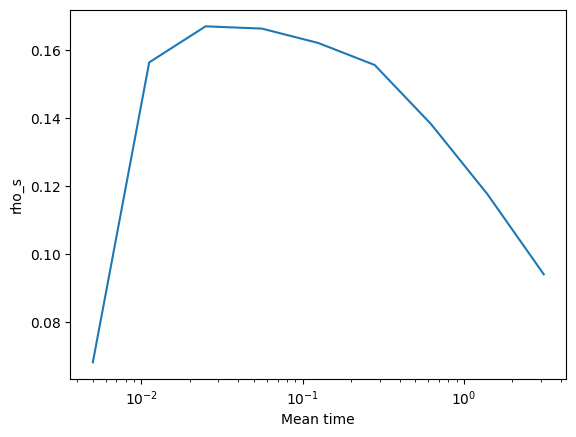

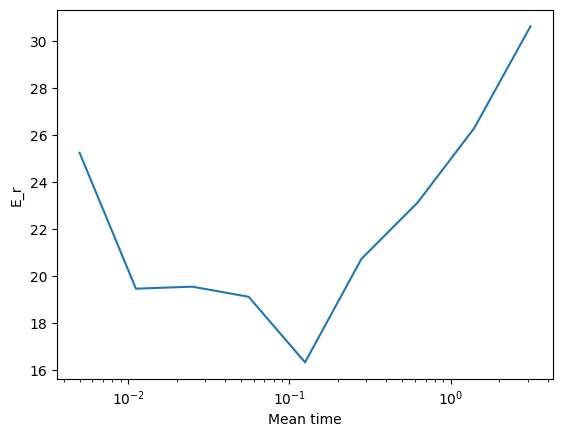

In [1]:
import matplotlib.pyplot as plt
from math import sqrt
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed

num_nodes = 100
mean_backoff = 0.005 # Valeur initiale
idle_time = 0.17

def run_simulation(_mean_backoff):
    # Convertir mean_backoff en chaîne de caractères avec suffixe 's'
    mean_backoff_str = f"{_mean_backoff}s"
    x_val = _mean_backoff
    
    # Créer le chemin du fichier
    file = f"out_{mean_backoff_str}.tr"
    file_path = f"./trace_Loss_res/{file}"
    
    # Créer le fichier
    subprocess.run(["touch", file_path])

    # Lancer la simulation ns
    res = subprocess.run(["ns", "./sat-aloha2.tcl", "poisson", mean_backoff_str, str(num_nodes), str(idle_time), file], cwd="./trace_Loss_res/")
    if res.returncode != 0:
        print(f"Error running simulation for mean_backoff {_mean_backoff}")
        return None
    # Calculer rho_s
    res = subprocess.run(["perl", "./trace_Loss/loss.pl", file_path], capture_output=True, text=True)
    if res.returncode == 0:
        rho_s = float(res.stdout.split()[-1])
    else:
        print(res.stderr)
        rho_s = None
    
    # Calculer E_r
    subprocess.run(["perl", "./trace_Response/response.pl", file_path], stdout=open("./trace_Response/response.out", "w"))
    subprocess.run(["perl", "./trace_Response/avr_response.pl", "./trace_Response/response.out"], stdout=open("./trace_Response/avr_response.out", "w"))
    
    with open("./trace_Response/avr_response.out", "r") as file:
        lines = file.readlines()
        last_line = lines[-1].strip()
        E_r = float(last_line.split()[3])
    
    # Supprimer les fichiers
    subprocess.run(["rm", "-rf", file_path])
    
    return x_val, rho_s, E_r

x, y, y2 = [], [], []
futures = []

# Utilisation de ThreadPoolExecutor pour exécuter les simulations en parallèle
with ThreadPoolExecutor() as executor:
    while mean_backoff < 5:
        futures.append(executor.submit(run_simulation, mean_backoff))
        mean_backoff *= sqrt(5)

    # Collecter les résultats au fur et à mesure qu'ils sont complétés
    for future in as_completed(futures):
        result = future.result()
        if result:
            x_val, rho_s, E_r = result
            x.append(x_val)
            if rho_s is not None:
                y.append(rho_s)
            if E_r is not None:
                y2.append(E_r)

# Tri des résultats
x, y, y2 = zip(*sorted(zip(x, y, y2)))

# Tracer les résultats
plt.semilogx(x, y)
plt.xlabel("Mean time")
plt.ylabel("rho_s")
plt.show()

plt.semilogx(x, y2)
plt.xlabel("Mean time")
plt.ylabel("E_r")
plt.show()


### Influence du nombre de nœuds sur la charge en sortie

On veut maintenant étudier l'influence du nombre de nœuds sur la charge en sortie du système. On garde notre valeur de $\verb|mean_backoff|$ optimale (à remplir) ainsi que notre débit global d'arrivée des trames. Ainsi à $\lambda$ fixé et $N$ voulu : 
$$\text{idle\_time}=\dfrac{N}{\lambda}$$



In [4]:
import subprocess
from matplotlib import pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

mean_backoff = 0.05  # à remplir
num_nodes_start = 10  # N à faire varier
num_nodes_end = 250
pas = 10

def run_simulation(num_nodes):
    # Calculer idle_time en fonction de num_nodes
    idle_time = (0.17 / 100) * num_nodes
    x_val = num_nodes
    
    # Créer le chemin du fichier
    file = f"out_{num_nodes}.tr"
    file_path = f"./trace_Loss_res/{file}"
    
    # Créer le fichier
    subprocess.run(["touch", file_path])

    # Lancer la simulation ns
    subprocess.run(["ns", "./sat-aloha2.tcl", "poisson", f"{mean_backoff}s", str(num_nodes), str(idle_time), file], cwd="./trace_Loss_res/")
    
    # Exécuter le script Perl pour traiter les résultats
    res = subprocess.run(["perl", "./trace_Loss/loss.pl", file_path], capture_output=True, text=True)
    
    # Supprimer le fichier
    subprocess.run(["rm", "-rf", file_path])
    
    if res.returncode == 0:
        rho_s = float(res.stdout.split()[-1])
    else:
        print(f"Error executing subprocesses for num_nodes = {num_nodes}")
        rho_s = None

    return x_val, rho_s

x, y = [], []
futures = []

# Utilisation de ThreadPoolExecutor pour exécuter les simulations en parallèle
with ThreadPoolExecutor() as executor:
    num_nodes = num_nodes_start
    while num_nodes <= num_nodes_end:
        futures.append(executor.submit(run_simulation, num_nodes))
        num_nodes += pas

    # Collecter les résultats au fur et à mesure qu'ils sont complétés
    for future in as_completed(futures):
        result = future.result()
        if result:
            x_val, rho_s = result
            x.append(x_val)
            if rho_s is not None:
                y.append(rho_s)

# Tri des résultats
x, y = zip(*sorted(zip(x, y)))
# Tracer les résultats
plt.plot(x, y)
plt.xlabel("num nodes")
plt.ylabel("rho_s")
plt.title("Relation entre le nombre de noeuds et rho_s")
plt.show()


KeyboardInterrupt: 

Analyser les résultats obtenus